# Notebook de Inferência CoDE para Colab

Este notebook testa o modelo CoDE com dataset ELSA_D3 em streaming, inferência visual com os 3 classificadores (Linear, KNN, SVM) e bateria de testes.

## 1. Montar Drive e verificar GPU

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import torch
print('CUDA disponível:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('Device:', torch.cuda.get_device_name(0))

Mounted at /content/drive
CUDA disponível: True
Device: Tesla T4


## 2. Clonar repositório e instalar dependências

In [2]:
# Clone do CoDE. Use seu fork se tiver elsa_streaming_loader e benchmark_classifiers.
%cd /content
!git clone https://github.com/RyanBarbalho/CoDE.git
%cd CoDE
!pip install transformers torch torchvision Pillow scikit-learn joblib huggingface-hub datasets requests

/content
Cloning into 'CoDE'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 197 (delta 50), reused 128 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (197/197), 11.92 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/CoDE


## 3. Configurar path e carregar os 3 modelos

In [3]:
import sys
import os

REPO_ROOT = '/content/CoDE'
sys.path.insert(0, os.path.join(REPO_ROOT, 'src', 'inference'))

from code_model import VITContrastiveHF
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models = {
    'linear': VITContrastiveHF(classificator_type='linear'),
    'knn': VITContrastiveHF(classificator_type='knn'),
    'svm': VITContrastiveHF(classificator_type='svm'),
}

for name, model in models.items():
    model.eval()
    model.model.to(device)

print('3 modelos carregados: linear, knn, svm')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

ViTModel LOAD REPORT from: aimagelab/CoDE
Key                 | Status  | 
--------------------+---------+-
pooler.dense.bias   | MISSING | 
pooler.dense.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


preprocessor_config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

The image processor of type `ViTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


linear_tot_classifier_epoch-32.sav:   0%|          | 0.00/2.40k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

ViTModel LOAD REPORT from: aimagelab/CoDE
Key                 | Status  | 
--------------------+---------+-
pooler.dense.bias   | MISSING | 
pooler.dense.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


sklearn/knn_tot_classifier_epoch-32.sav:   0%|          | 0.00/37.2M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

ViTModel LOAD REPORT from: aimagelab/CoDE
Key                 | Status  | 
--------------------+---------+-
pooler.dense.bias   | MISSING | 
pooler.dense.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


sklearn/ocsvm_kernel_poly_gamma_auto_nu_(…):   0%|          | 0.00/2.32M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


3 modelos carregados: linear, knn, svm


## 4. Carregar dados via streaming (ELSA_D3)

In [4]:
import torchvision.transforms as transforms
from elsa_streaming_loader import elsa_streaming_samples

transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Coletar N imagens para o grid visual (apenas fakes, mais rápido)
NUM_VISUAL = 12
visual_samples = []
for img, label, arch in elsa_streaming_samples(max_samples=NUM_VISUAL, use_real_images=True):
    img_t = transform(img)
    visual_samples.append((img_t, label, arch))

print(f'Coletadas {len(visual_samples)} imagens para visualização')

README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/5254 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/5254 [00:00<?, ?it/s]

Coletadas 12 imagens para visualização


## 5. Inferência visual – grid com predições dos 3 classificadores

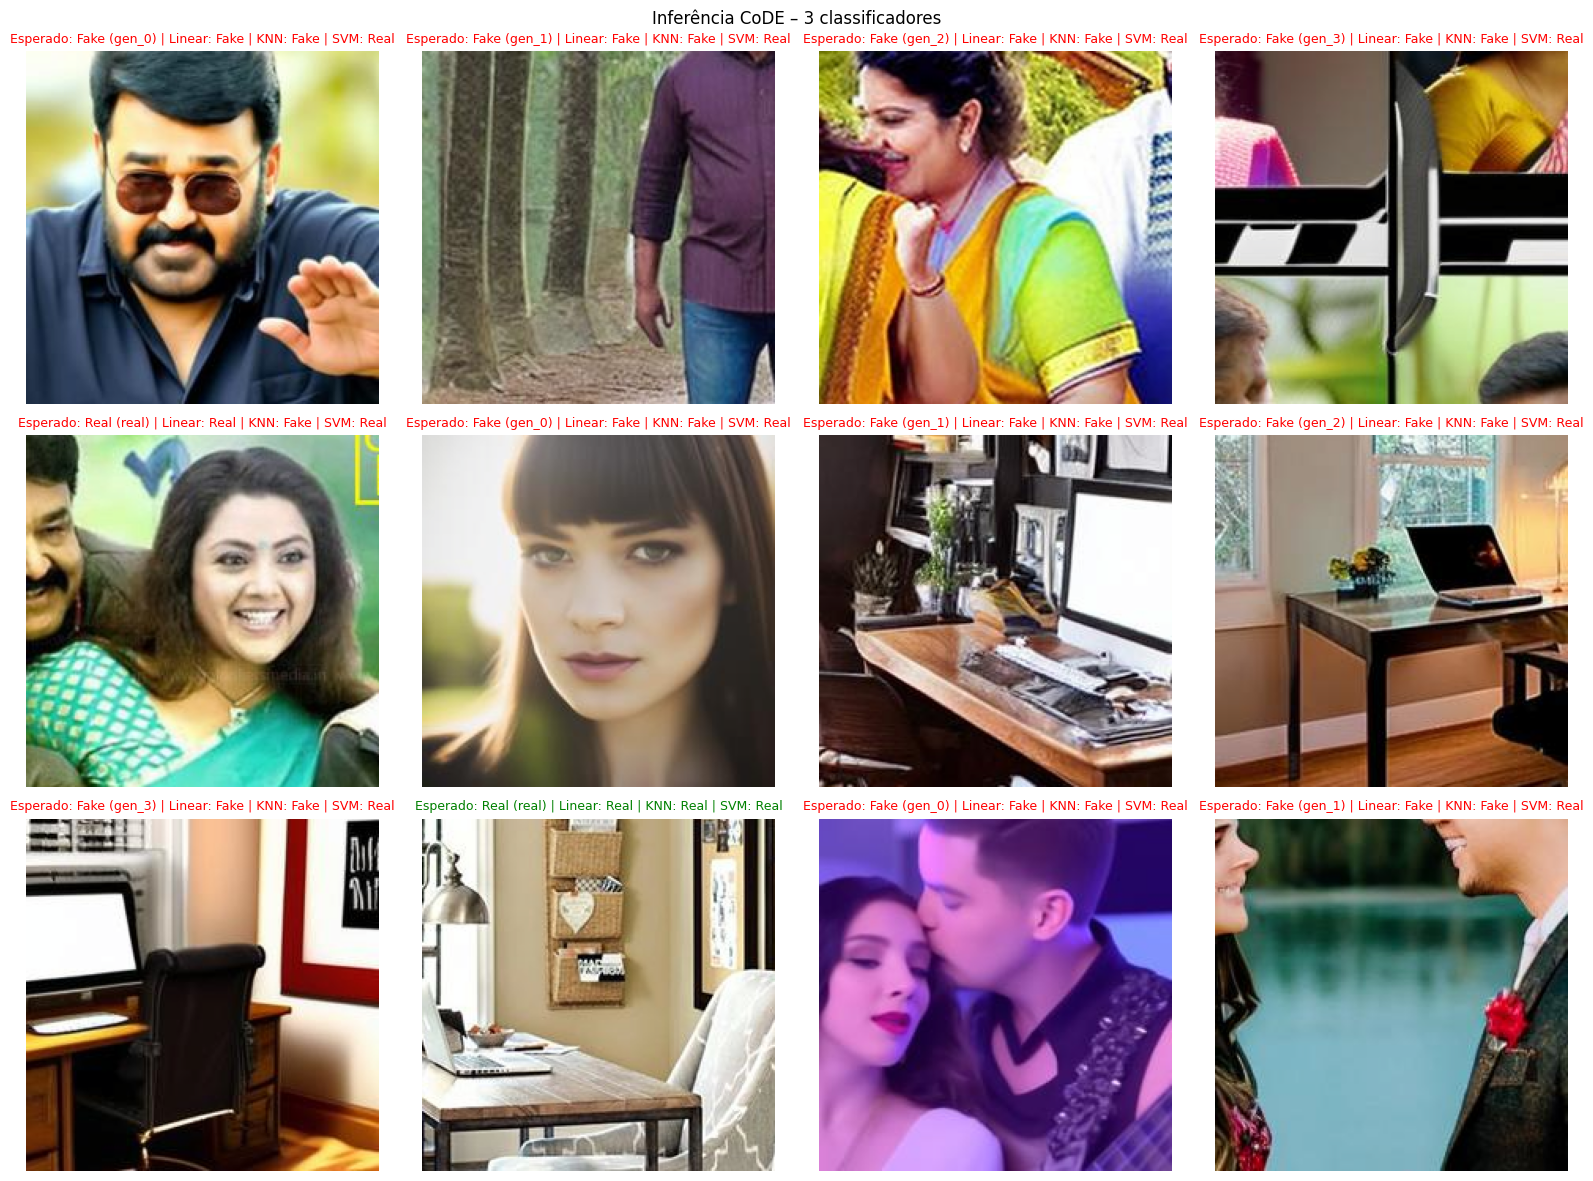

In [5]:
import matplotlib.pyplot as plt
import numpy as np

LABELS = ['Real', 'Fake']
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def tensor_to_img(t):
    x = t.cpu().numpy().transpose(1, 2, 0)
    x = x * std + mean
    return np.clip(x, 0, 1)

def pred_to_label(pred, ctype):
    if ctype == 'svm':
        return 'Real' if pred == -1 else 'Fake'
    return LABELS[int(pred)]

cols, rows = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for i, (img_tensor, true_label, arch) in enumerate(visual_samples):
    if i >= len(axes):
        break
    x = img_tensor.unsqueeze(0).to(device)
    preds = {}
    with torch.no_grad():
        for ctype, model in models.items():
            p = model(x).item()
            preds[ctype] = pred_to_label(p, ctype)

    true_str = LABELS[true_label]
    title = f'Esperado: {true_str} ({arch}) | Linear: {preds["linear"]} | KNN: {preds["knn"]} | SVM: {preds["svm"]}'

    all_correct = all(preds[c] == true_str for c in ['linear', 'knn', 'svm'])
    color = 'green' if all_correct else 'red'

    axes[i].imshow(tensor_to_img(img_tensor))
    axes[i].axis('off')
    axes[i].set_title(title, fontsize=9, color=color)

for j in range(len(visual_samples), len(axes)):
    axes[j].axis('off')

plt.suptitle('Inferência CoDE – 3 classificadores', fontsize=12)
plt.tight_layout()
plt.show()

## 6. Bateria de testes (benchmark dos 3 classificadores)

In [6]:
%cd /content/CoDE/src/inference
!python benchmark_classifiers.py --streaming --max_samples 500 --result_folder /content/CoDE/results

/content/CoDE/src/inference
Loading weights: 100% 198/198 [00:00<00:00, 1314.30it/s, Materializing param=layernorm.weight]
ViTModel LOAD REPORT from: aimagelab/CoDE
Key                 | Status  | 
--------------------+---------+-
pooler.dense.weight | MISSING | 
pooler.dense.bias   | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
The image processor of type `ViTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. 

### Alternativa: bateria no próprio notebook

In [7]:
import sys
sys.path.insert(0, '/content/CoDE/src/inference')

from benchmark_classifiers import run_benchmark_streaming, print_results

class Opt:
    max_samples = 500
    use_real_images = True
    batch_size = 128

opt = Opt()
results, n_total = run_benchmark_streaming(opt)
print_results(results, n_total)

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

ViTModel LOAD REPORT from: aimagelab/CoDE
Key                 | Status  | 
--------------------+---------+-
pooler.dense.bias   | MISSING | 
pooler.dense.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
linear: 0it [00:00, ?it/s]

Resolving data files:   0%|          | 0/5254 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/5254 [00:00<?, ?it/s]

linear: 1it [00:19, 19.74s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
linear: 2it [00:32, 15.39s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
linear: 4it [01:18, 19.60s/it]


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

ViTModel LOAD REPORT from: aimagelab/CoDE
Key                 | Status  | 
--------------------+---------+-
pooler.dense.bias   | MISSING | 
pooler.dense.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
knn: 0it [00:00, ?it/s]

Resolving data files:   0%|          | 0/5254 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/5254 [00:00<?, ?it/s]

knn: 1it [00:21, 21.47s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
knn: 2it [00:30, 14.15s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
knn: 4it [01:03, 15.91s/it]


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

ViTModel LOAD REPORT from: aimagelab/CoDE
Key                 | Status  | 
--------------------+---------+-
pooler.dense.bias   | MISSING | 
pooler.dense.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneClassSVM from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
svm: 0it [00:00, ?it/s]

Resolving data files:   0%|          | 0/5254 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/5254 [00:00<?, ?it/s]

svm: 1it [00:18, 18.69s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
svm: 2it [00:28, 13.21s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
svm: 4it [01:00, 15.19s/it]


=== Bateria de testes CoDE ===
Dataset: 500 amostras
--------------------------------------------------
Classificador | Acc Real   | Acc Fake   | Acc Total 
--------------------------------------------------
linear       |    98.67   |    92.00   |    93.00   
knn          |    93.42   |    95.75   |    95.40   
svm          |    85.53   |    94.81   |    93.40   
--------------------------------------------------


## 7. Inferência com dataset proprio (real + fake)

Use as células abaixo para inferência visual e em batch no seu dataset local. O `opt` deve ter `real_path`, `fake_path` e `data_mode` definidos na célula anterior.


In [8]:
class Opt:
    real_path = "/content/drive/MyDrive/tcc/CoDE/teste_inferencia/real_path"
    fake_path = "/content/drive/MyDrive/tcc/CoDE/teste_inferencia/fake_path"
    data_mode = "ours"
    batch_size = 128
    num_workers = 0

opt = Opt()

real: 10, fake: 25
Total: 35 imagens


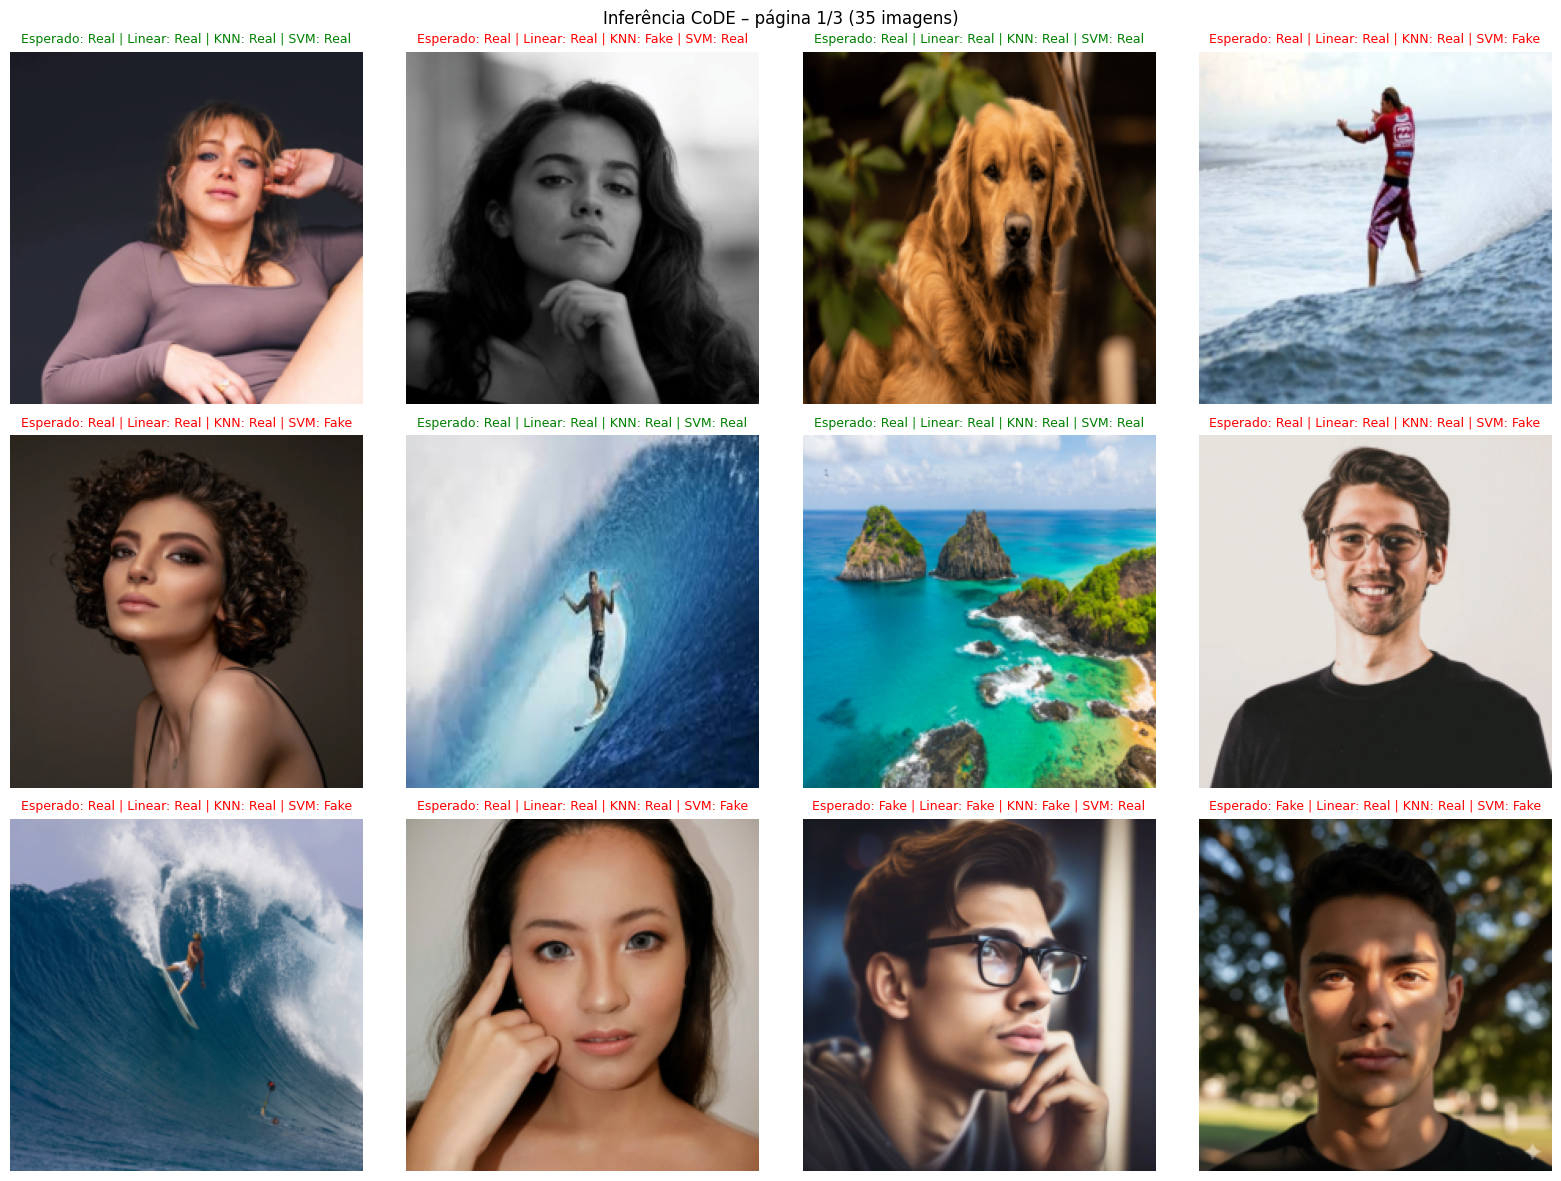

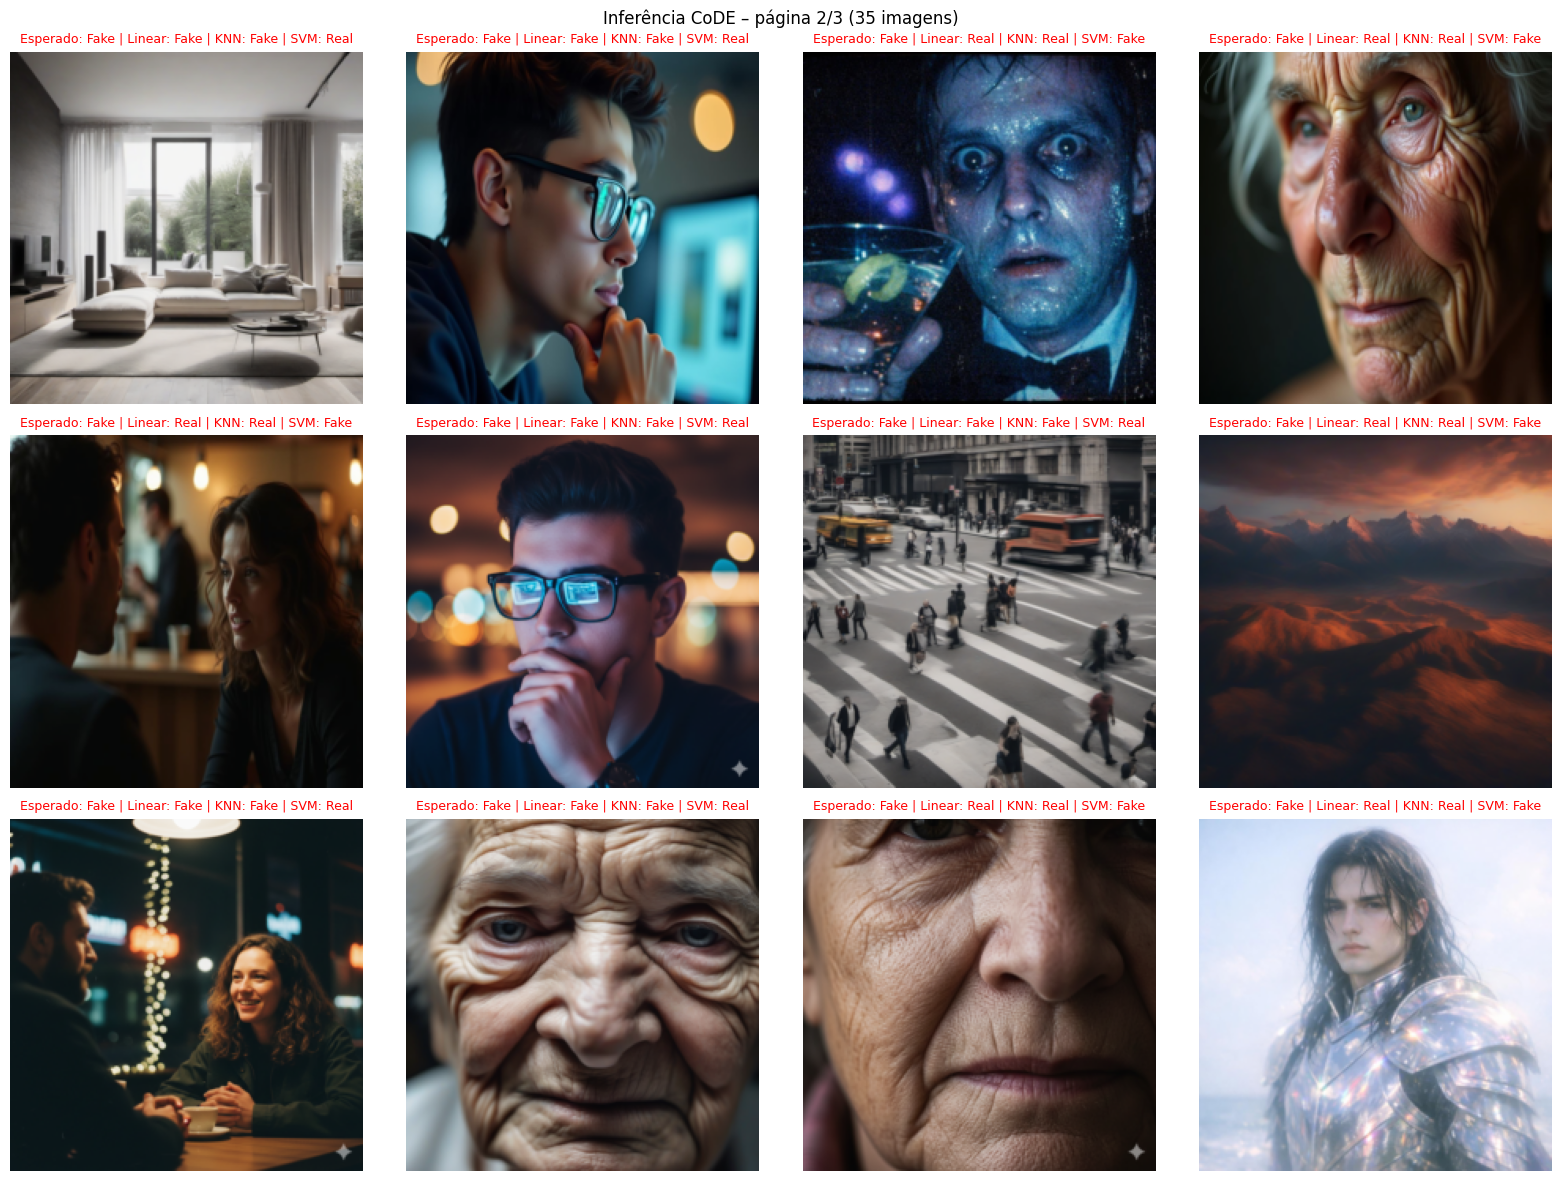

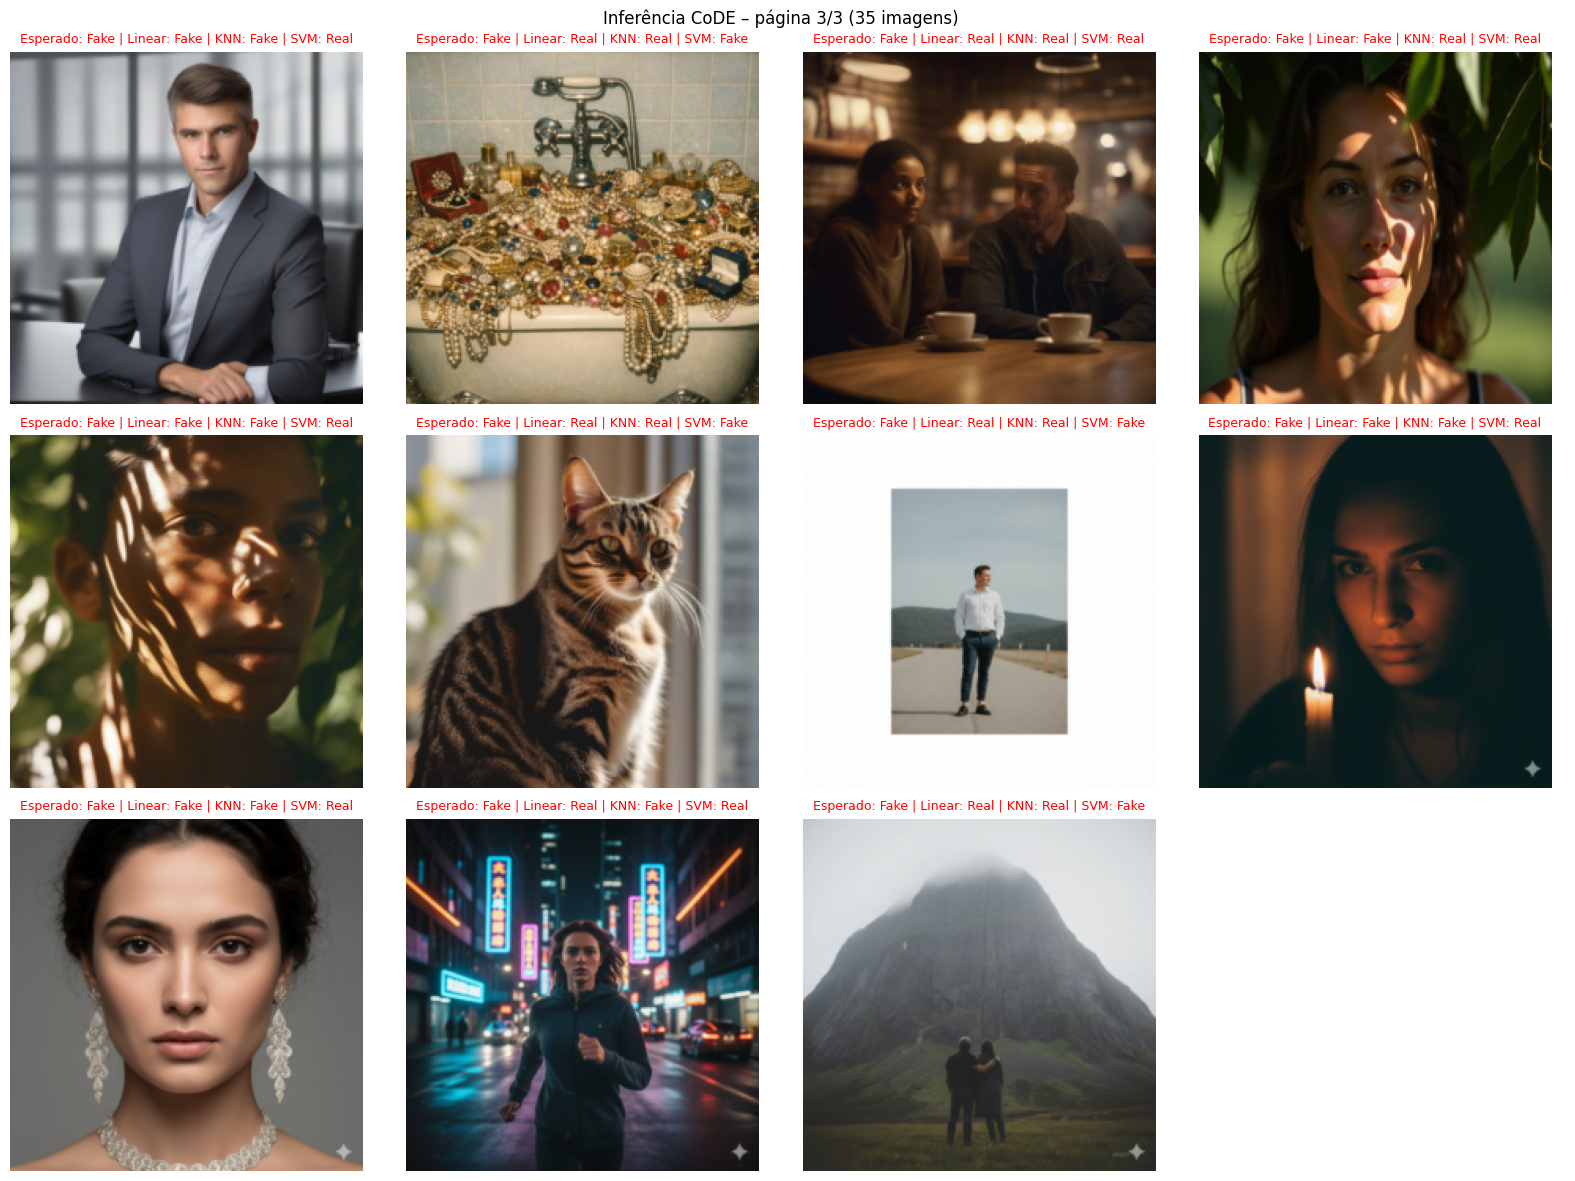

In [9]:
# Inferência visual – grid com predições dos 3 classificadores (TODAS as imagens)
import sys
sys.path.insert(0, '/content/CoDE/src/inference')
import numpy as np
import matplotlib.pyplot as plt

from validate_d3 import RealFakeDataset
from benchmark_classifiers import get_transform

transform = get_transform()
dataset = RealFakeDataset(opt.real_path, opt.fake_path, opt.data_mode, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, shuffle=False, num_workers=opt.num_workers)

# Coletar as amostras do dataset
visual_samples = []
for img_t, label, path in loader:
    for i in range(len(img_t)):
        visual_samples.append((img_t[i], label[i].item(), path[i]))

print(f'Total: {len(visual_samples)} imagens')

LABELS = ['Real', 'Fake']
def pred_to_label(pred, ctype):
    if ctype == 'svm':
        return 'Real' if pred == -1 else 'Fake'
    return LABELS[int(pred)]
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def tensor_to_img(t):
    x = t.cpu().numpy().transpose(1, 2, 0) * std + mean
    return np.clip(x, 0, 1)

# Exibir em páginas de IMGS_PER_PAGE imagens
IMGS_PER_PAGE = 12
cols, rows = 4, 3

for page_start in range(0, len(visual_samples), IMGS_PER_PAGE):
    page_samples = visual_samples[page_start:page_start + IMGS_PER_PAGE]
    page_num = page_start // IMGS_PER_PAGE + 1
    n_pages = (len(visual_samples) + IMGS_PER_PAGE - 1) // IMGS_PER_PAGE

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten()

    for i, (img_tensor, true_label, path) in enumerate(page_samples):
        x = img_tensor.unsqueeze(0).to(device)
        preds = {}
        with torch.no_grad():
            for ctype, model in models.items():
                p = model(x).item()
                preds[ctype] = pred_to_label(p, ctype)
        true_str = LABELS[true_label]
        title = f'Esperado: {true_str} | Linear: {preds["linear"]} | KNN: {preds["knn"]} | SVM: {preds["svm"]}'
        all_correct = all(preds[c] == true_str for c in ['linear', 'knn', 'svm'])
        color = 'green' if all_correct else 'red'
        axes[i].imshow(tensor_to_img(img_tensor))
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=9, color=color)

    for j in range(len(page_samples), len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Inferência CoDE – página {page_num}/{n_pages} ({len(visual_samples)} imagens)', fontsize=12)
    plt.tight_layout()
    plt.show()

In [10]:
# Inferência em batch – salvar resultados em CSV
import sys
sys.path.insert(0, '/content/CoDE/src/inference')
import csv
import os
from tqdm import tqdm

from validate_d3 import RealFakeDataset
from benchmark_classifiers import get_transform

transform = get_transform()

def pred_to_str(p, ctype):
    if ctype == 'svm':
        return 'Real' if p == -1 else 'Fake'
    return 'Real' if p < 0.5 else 'Fake'

dataset = RealFakeDataset(opt.real_path, opt.fake_path, opt.data_mode, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, shuffle=False, num_workers=opt.num_workers)

rows = []
for imgs, labels, paths in tqdm(loader, desc='Batch inference'):
    imgs = imgs.cuda()
    preds_all = {ctype: [] for ctype in ['linear', 'knn', 'svm']}
    with torch.no_grad():
        for ctype, model in models.items():
            out = model(imgs).flatten().tolist()
            preds_all[ctype] = out
    for i, (path, true_label) in enumerate(zip(paths, labels.tolist())):
        rows.append({
            'path': path,
            'true': 'Real' if true_label == 0 else 'Fake',
            'linear': pred_to_str(preds_all['linear'][i], 'linear'),
            'knn': pred_to_str(preds_all['knn'][i], 'knn'),
            'svm': pred_to_str(preds_all['svm'][i], 'svm'),
        })

out_csv = '/content/CoDE/results/inferencia_meu_dataset.csv'
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
with open(out_csv, 'w', newline='', encoding='utf-8') as f:
    w = csv.DictWriter(f, fieldnames=['path', 'true', 'linear', 'knn', 'svm'])
    w.writeheader()
    w.writerows(rows)

# Calcular e exibir acurácia por classificador
import numpy as np
trues = np.array([r['true'] for r in rows])
n_real = np.sum(trues == 'Real')
n_fake = np.sum(trues == 'Fake')

print("\n=== Acurácia no seu dataset ===")
print(f"Dataset: {len(rows)} amostras ({n_real} reais, {n_fake} fakes)")
print("-" * 52)
print(f"{'Classificador':<12} | {'Acc Real':<10} | {'Acc Fake':<10} | {'Acc Total':<10}")
print("-" * 52)

for ctype in ['linear', 'knn', 'svm']:
    preds = np.array([r[ctype] for r in rows])
    acc_real = 100 * np.mean(preds[trues == 'Real'] == 'Real') if n_real > 0 else np.nan
    acc_fake = 100 * np.mean(preds[trues == 'Fake'] == 'Fake') if n_fake > 0 else np.nan
    acc_total = 100 * np.mean(preds == trues)
    r_str = f"{acc_real:.2f}" if not np.isnan(acc_real) else "   nan"
    f_str = f"{acc_fake:.2f}" if not np.isnan(acc_fake) else "   nan"
    print(f"{ctype:<12} | {r_str:>8}   | {f_str:>8}   | {acc_total:>8.2f}   ")
print("-" * 52)
print(f"\nResultados salvos em {out_csv}")

real: 10, fake: 25


Batch inference: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


=== Acurácia no seu dataset ===
Dataset: 35 amostras (10 reais, 25 fakes)
----------------------------------------------------
Classificador | Acc Real   | Acc Fake   | Acc Total 
----------------------------------------------------
linear       |   100.00   |    48.00   |    62.86   
knn          |    90.00   |    48.00   |    60.00   
svm          |    50.00   |    44.00   |    45.71   
----------------------------------------------------

Resultados salvos em /content/CoDE/results/inferencia_meu_dataset.csv


In [11]:
import pandas as pd

df = pd.read_csv('/content/CoDE/results/inferencia_meu_dataset.csv')

# Consenso
df['consenso'] = (df['linear'] == df['knn']) & (df['knn'] == df['svm'])
print(f"Taxa de consenso (3 concordam): {df['consenso'].mean()*100:.1f}%")

# Casos difíceis (todos erraram)
df['correto'] = (df['linear'] == df['true']) & (df['knn'] == df['true']) & (df['svm'] == df['true'])
dificeis = df[~df['correto']]
print(f"Casos em que pelo menos 1 errou: {len(dificeis)} ({len(dificeis)/len(df)*100:.1f}%)")

# Matriz de concordância
from sklearn.metrics import confusion_matrix
# Ex: confusion matrix para Linear vs ground truth

Taxa de consenso (3 concordam): 14.3%
Casos em que pelo menos 1 errou: 31 (88.6%)


In [12]:
# Análise de insights – consenso, casos difíceis, métricas por classe
import pandas as pd
import numpy as np

df = pd.read_csv('/content/CoDE/results/inferencia_meu_dataset.csv')

# Consenso: os 3 classificadores concordam
df['consenso'] = (df['linear'] == df['knn']) & (df['knn'] == df['svm'])

# Taxa de consenso total (Real + Fake)
consenso_total = df['consenso'].mean() * 100
print("=== Taxa de consenso (3 classificadores concordam) ===")
print(f"Considerando todos (Real + Fake): {consenso_total:.1f}% ({df['consenso'].sum()}/{len(df)})")

# Taxa de consenso só em REAIS
mask_real = df['true'] == 'Real'
if mask_real.any():
    consenso_real = df.loc[mask_real, 'consenso'].mean() * 100
    n_real = mask_real.sum()
    print(f"Apenas imagens REAIS:          {consenso_real:.1f}% ({df.loc[mask_real, 'consenso'].sum()}/{n_real})")
else:
    print("Apenas imagens REAIS:          (nenhuma amostra)")

# Taxa de consenso só em FAKES
mask_fake = df['true'] == 'Fake'
if mask_fake.any():
    consenso_fake = df.loc[mask_fake, 'consenso'].mean() * 100
    n_fake = mask_fake.sum()
    print(f"Apenas imagens FAKES:          {consenso_fake:.1f}% ({df.loc[mask_fake, 'consenso'].sum()}/{n_fake})")
else:
    print("Apenas imagens FAKES:          (nenhuma amostra)")

# Casos difíceis (pelo menos 1 classificador errou)
df['correto_todos'] = (df['linear'] == df['true']) & (df['knn'] == df['true']) & (df['svm'] == df['true'])
dificeis = df[~df['correto_todos']]
print(f"\nCasos difíceis (≥1 errou): {len(dificeis)} ({len(dificeis)/len(df)*100:.1f}%)")

# Quando todos concordam, qual a acurácia?
quando_consenso = df[df['consenso']]
if len(quando_consenso) > 0:
    acc_quando_consenso = (quando_consenso['linear'] == quando_consenso['true']).mean() * 100
    print(f"Acurácia quando há consenso:   {acc_quando_consenso:.1f}%")

# Divergência (pelo menos 2 valores diferentes entre linear, knn, svm)
df['divergencia'] = ~df['consenso']
print(f"\nDivergências (≥1 discorda):  {df['divergencia'].sum()} ({df['divergencia'].mean()*100:.1f}%)")

=== Taxa de consenso (3 classificadores concordam) ===
Considerando todos (Real + Fake): 14.3% (5/35)
Apenas imagens REAIS:          40.0% (4/10)
Apenas imagens FAKES:          4.0% (1/25)

Casos difíceis (≥1 errou): 31 (88.6%)
Acurácia quando há consenso:   80.0%

Divergências (≥1 discorda):  30 (85.7%)
